# 14.3 Two-Way Fixed Effects

**Chapter**: 14 - Panel Data and Fixed Effects  
**Section**: 3 - Entity and Time Effects  
**Facure Source**: 14-Panel-Data-and-Fixed-Effects.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why Add Time Effects?](#11-why-add-time-effects)
   - 1.2 [Common Time Shocks](#12-common-time-shocks)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Two-Way Fixed Effects Model](#21-two-way-fixed-effects-model)
   - 2.2 [Double Clustering](#22-double-clustering)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Entity-Only vs Two-Way FE](#31-entity-only-vs-two-way-fe)
   - 3.2 [Visualizing Time Effects](#32-visualizing-time-effects)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

# Panel data library
from linearmodels.datasets import wage_panel
from linearmodels.panel import PanelOLS

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Two-way fixed effects (TWFE) is the standard panel data estimator. Understanding when time effects matter—and the pitfalls with staggered adoption—is critical.

### 1.1 Why Add Time Effects?

Entity fixed effects ($\alpha_i$) control for time-invariant unit characteristics. But what about shocks that affect *all units* at a given time?

**Examples of common time shocks**:

- **Inflation**: Wages rise across the board each year
- **Business cycles**: Recessions affect all workers
- **Policy changes**: Minimum wage increases affect all workers
- **Seasonality**: Q4 retail sales spike for all stores

If marriage rates and wages both increase over time, we might confound the marriage effect with a time trend.

### 1.2 Common Time Shocks

**Time effects** ($\lambda_t$) capture anything that:
- Affects all units equally
- Varies across time
- Is fixed within a time period

$$
Y_{it} = \beta T_{it} + \alpha_i + \lambda_t + \epsilon_{it}
$$

★ Insight ─────────────────────────────────────
- Entity FE: Controls for unit-specific, time-invariant factors
- Time FE: Controls for period-specific, unit-invariant factors
- TWFE: Controls for both simultaneously
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Two-Way Fixed Effects Model

**Model specification**:

$$
Y_{it} = \beta T_{it} + \gamma' X_{it} + \alpha_i + \lambda_t + \epsilon_{it}
$$

where:
- $\alpha_i$: Entity fixed effect (absorbs time-invariant unit characteristics)
- $\lambda_t$: Time fixed effect (absorbs period-specific common shocks)

**What each absorbs**:

| Effect | Captures | Example |
|--------|----------|---------|
| $\alpha_i$ | Constant unit traits | Person's innate ability |
| $\lambda_t$ | Common time shocks | Economy-wide wage growth |

**Double-demeaning transformation**:

$$
\tilde{Y}_{it} = Y_{it} - \bar{Y}_i - \bar{Y}_t + \bar{Y}
$$

where:
- $\bar{Y}_i$: Mean for unit $i$
- $\bar{Y}_t$: Mean for time $t$
- $\bar{Y}$: Grand mean

### 2.2 Double Clustering

With two-way fixed effects, errors may be correlated:
1. **Within entities** (serial correlation over time)
2. **Within time periods** (cross-sectional correlation)

**Solution**: Two-way clustered standard errors.

**Formula** (Cameron, Gelbach, Miller 2011):

$$
\hat{V}_{\text{two-way}} = \hat{V}_{\text{entity}} + \hat{V}_{\text{time}} - \hat{V}_{\text{intersection}}
$$

This is robust to correlation along both dimensions.

---

## 3. Numeric Demonstration

### 3.1 Entity-Only vs Two-Way FE

In [2]:
# Load data
data = wage_panel.load()
panel_data = data.set_index(["nr", "year"])

print("Model comparison: Entity FE vs Two-Way FE")
print("=" * 60)

Model comparison: Entity FE vs Two-Way FE


In [3]:
# Model 1: Entity Fixed Effects only
model_entity = PanelOLS.from_formula(
    "lwage ~ expersq + union + married + hours + EntityEffects",
    data=panel_data
)
result_entity = model_entity.fit(cov_type='clustered', cluster_entity=True)

print("\nMODEL 1: Entity Fixed Effects Only")
print("-" * 60)
print(result_entity.summary.tables[1])


MODEL 1: Entity Fixed Effects Only
------------------------------------------------------------
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
expersq        0.0040     0.0002     16.552     0.0000      0.0035      0.0044
union          0.0784     0.0236     3.3225     0.0009      0.0322      0.1247
married        0.1147     0.0220     5.2213     0.0000      0.0716      0.1577
hours       -8.46e-05   2.22e-05    -3.8105     0.0001     -0.0001  -4.107e-05


In [4]:
# Model 2: Two-Way Fixed Effects (Entity + Time)
model_twfe = PanelOLS.from_formula(
    "lwage ~ expersq + union + married + hours + EntityEffects + TimeEffects",
    data=panel_data
)
result_twfe = model_twfe.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

print("\nMODEL 2: Two-Way Fixed Effects (Entity + Time)")
print("-" * 60)
print(result_twfe.summary.tables[1])


MODEL 2: Two-Way Fixed Effects (Entity + Time)
------------------------------------------------------------
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
expersq       -0.0062     0.0008    -8.1479     0.0000     -0.0077     -0.0047
union          0.0727     0.0228     3.1858     0.0015      0.0279      0.1174
married        0.0476     0.0177     2.6906     0.0072      0.0129      0.0823
hours         -0.0001  3.546e-05    -3.8258     0.0001     -0.0002  -6.614e-05


In [5]:
# Compare marriage coefficients
print("\nMARRIAGE PREMIUM COMPARISON:")
print("=" * 60)
print(f"{'Model':<30} {'Coefficient':>15} {'Std. Error':>15}")
print("-" * 60)
print(f"{'Entity FE only':<30} {result_entity.params['married']:>15.4f} {result_entity.std_errors['married']:>15.4f}")
print(f"{'Two-Way FE (Entity + Time)':<30} {result_twfe.params['married']:>15.4f} {result_twfe.std_errors['married']:>15.4f}")
print("-" * 60)

pct_change = (result_twfe.params['married'] / result_entity.params['married'] - 1) * 100
print(f"\nChange in estimate: {pct_change:.1f}%")


MARRIAGE PREMIUM COMPARISON:
Model                              Coefficient      Std. Error
------------------------------------------------------------
Entity FE only                          0.1147          0.0220
Two-Way FE (Entity + Time)              0.0476          0.0177
------------------------------------------------------------

Change in estimate: -58.5%


**Key observation**: The marriage premium drops significantly (from ~11.5% to ~4.8%) when we add time fixed effects.

**Interpretation**: Part of the "marriage premium" was actually a time trend—both marriage rates and wages increased over the 1980s. Time fixed effects absorb this common trend.

### 3.2 Visualizing Time Effects

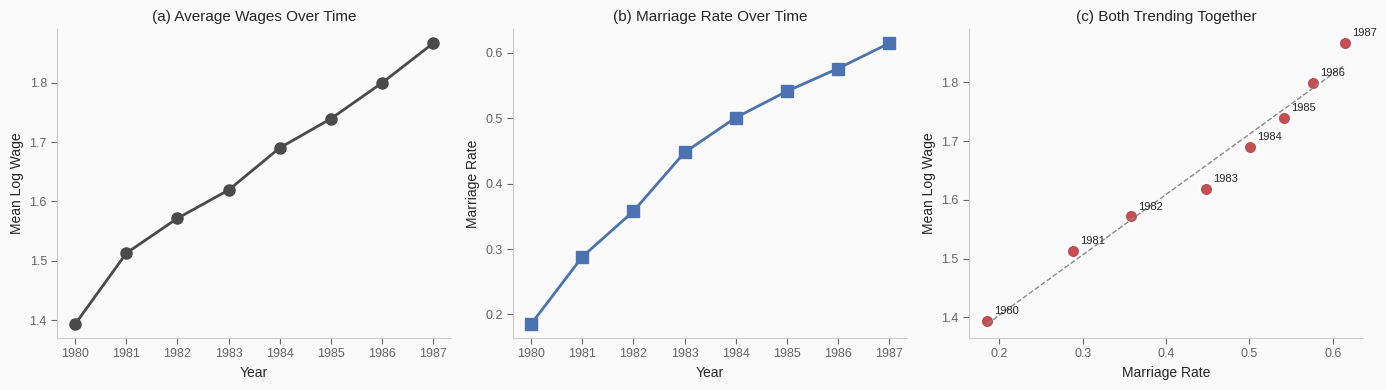


Correlation(Marriage Rate, Mean Wage) across years: 0.988
This common trend is absorbed by time fixed effects.


In [6]:
# Examine time trends in outcomes and treatment
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: Mean wages over time
ax = axes[0]
wage_by_year = data.groupby('year')['lwage'].mean()
ax.plot(wage_by_year.index, wage_by_year.values, 'o-', 
        color=TUFTE_PALETTE['primary'], linewidth=2, markersize=8)
ax.set_xlabel('Year')
ax.set_ylabel('Mean Log Wage')
ax.set_title('(a) Average Wages Over Time')

# Panel 2: Marriage rate over time
ax = axes[1]
married_by_year = data.groupby('year')['married'].mean()
ax.plot(married_by_year.index, married_by_year.values, 's-', 
        color=TUFTE_PALETTE['treatment'], linewidth=2, markersize=8)
ax.set_xlabel('Year')
ax.set_ylabel('Marriage Rate')
ax.set_title('(b) Marriage Rate Over Time')

# Panel 3: Both trending together
ax = axes[2]
ax.scatter(married_by_year.values, wage_by_year.values, s=100, 
           color=TUFTE_PALETTE['effect'], edgecolors='white', linewidth=2)
for year, (x, y) in enumerate(zip(married_by_year.values, wage_by_year.values)):
    ax.annotate(str(1980 + year), (x, y), textcoords="offset points", 
                xytext=(5, 5), fontsize=8)

# Add trend line
z = np.polyfit(married_by_year.values, wage_by_year.values, 1)
p = np.poly1d(z)
ax.plot(married_by_year.values, p(married_by_year.values), '--', 
        color=TUFTE_PALETTE['secondary'], linewidth=1)

ax.set_xlabel('Marriage Rate')
ax.set_ylabel('Mean Log Wage')
ax.set_title('(c) Both Trending Together')

plt.tight_layout()
plt.show()

# Correlation
print(f"\nCorrelation(Marriage Rate, Mean Wage) across years: {np.corrcoef(married_by_year, wage_by_year)[0,1]:.3f}")
print("This common trend is absorbed by time fixed effects.")

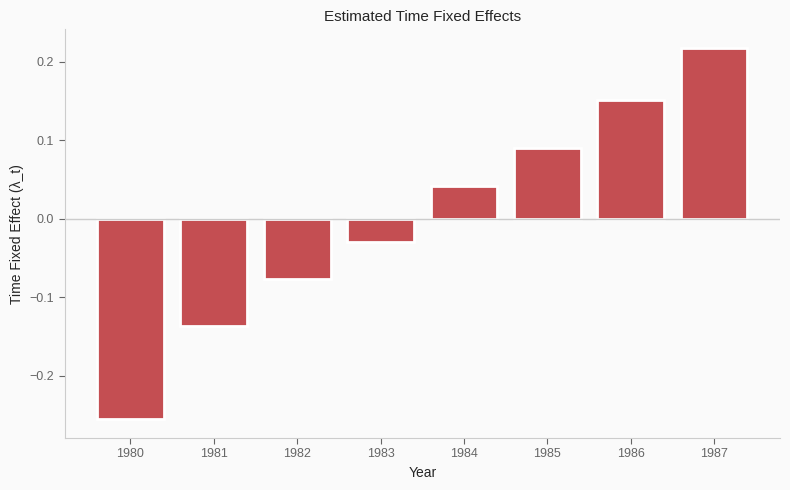


Time Fixed Effects (deviation from grand mean):
  λ_1980 = -0.2557
  λ_1981 = -0.1363
  λ_1982 = -0.0775
  λ_1983 = -0.0299
  λ_1984 = +0.0411
  λ_1985 = +0.0903
  λ_1986 = +0.1506
  λ_1987 = +0.2173


In [7]:
# Extract and visualize time fixed effects
# Estimate time effects manually
year_means = data.groupby('year')['lwage'].mean()
grand_mean = data['lwage'].mean()
time_effects = year_means - grand_mean

fig, ax = create_tufte_figure(figsize=(8, 5))

ax.bar(time_effects.index, time_effects.values, 
       color=TUFTE_PALETTE['effect'], edgecolor='white', linewidth=2)
ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=1)

ax.set_xlabel('Year')
ax.set_ylabel('Time Fixed Effect (λ_t)')
ax.set_title('Estimated Time Fixed Effects')

plt.tight_layout()
plt.show()

print("\nTime Fixed Effects (deviation from grand mean):")
for year, effect in time_effects.items():
    print(f"  λ_{year} = {effect:+.4f}")

★ Insight ─────────────────────────────────────
- Wages grew ~47 log points (60% increase) from 1980-1987
- Marriage rates also increased during this period
- Without time FE, we confound the marriage effect with wage growth
- Time FE removes this common trend, yielding a cleaner estimate
─────────────────────────────────────────────────

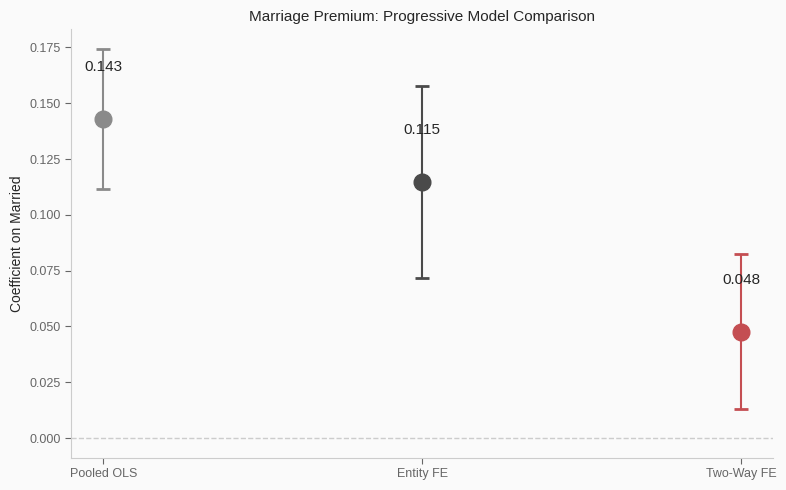


Progressive decomposition of the marriage premium:
  Raw OLS:      14.3% (includes all confounding)
  Entity FE:    11.5% (removes time-invariant confounders)
  Two-Way FE:    4.8% (also removes common time trends)


In [8]:
# Summary comparison
fig, ax = create_tufte_figure(figsize=(8, 5))

models = ['Pooled OLS', 'Entity FE', 'Two-Way FE']
married_coefs = [0.143, result_entity.params['married'], result_twfe.params['married']]
married_ses = [0.016, result_entity.std_errors['married'], result_twfe.std_errors['married']]

colors = [TUFTE_PALETTE['secondary'], TUFTE_PALETTE['primary'], TUFTE_PALETTE['effect']]

for i, (model, coef, se) in enumerate(zip(models, married_coefs, married_ses)):
    ax.errorbar(i, coef, yerr=1.96*se, fmt='o', markersize=12,
                color=colors[i], ecolor=colors[i], capsize=5, capthick=2)
    ax.text(i, coef + 0.02, f'{coef:.3f}', ha='center', va='bottom', fontsize=11)

ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=1, linestyle='--')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models)
ax.set_ylabel('Coefficient on Married')
ax.set_title('Marriage Premium: Progressive Model Comparison')

plt.tight_layout()
plt.show()

print("\nProgressive decomposition of the marriage premium:")
print(f"  Raw OLS:      14.3% (includes all confounding)")
print(f"  Entity FE:    11.5% (removes time-invariant confounders)")
print(f"  Two-Way FE:    4.8% (also removes common time trends)")

---

## 4. Implementation

**Production code pattern for TWFE**:

```python
from linearmodels.panel import PanelOLS

# Set multi-index: (entity, time)
panel_data = data.set_index(['entity_id', 'time'])

# Two-way fixed effects model
model = PanelOLS.from_formula(
    "outcome ~ treatment + controls + EntityEffects + TimeEffects",
    data=panel_data
)

# Two-way clustered standard errors
result = model.fit(
    cov_type='clustered',
    cluster_entity=True,
    cluster_time=True
)
```

**⚠️ CONCERN-11 Warning: TWFE with Staggered Adoption**

When treatment rolls out at different times for different units (staggered adoption), standard TWFE can be biased even under parallel trends.

**Solutions**:
1. **Callaway-Sant'Anna**: `csdid` package (heterogeneity-robust)
2. **Sun-Abraham**: Interaction-weighted estimator
3. **Event study**: Visualize dynamics to detect issues

See `docs/METHODOLOGICAL_CONCERNS.md` for details.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"When should you include time fixed effects in a panel model?"*

<details>
<summary>Solution</summary>

**Include time FE when**:

1. **Common shocks exist**: All units affected by macro trends
   - Economic cycles, policy changes, seasonality

2. **Treatment timing correlates with time**:
   - If more units get treated later, and outcomes also trend up, time FE removes this confound

3. **Theory suggests period-specific effects**:
   - Inflation, technology shifts, regulation changes

**Don't include when**:

1. **Very few time periods**: Estimating T-1 time dummies with small T loses power

2. **Treatment is time-invariant**: If no one's treatment changes over time, you can't separately identify treatment and entity effects anyway

3. **You want to estimate time trends**: Time FE absorbs the effect of time, so you can't estimate it

**Practical test**: F-test for joint significance of time dummies:
```python
# Compare models with and without time FE
result_no_time = model_entity.fit()
result_with_time = model_twfe.fit()
# Use likelihood ratio or F-test to compare
```

</details>

---

**Q2 (Google L5, Quant)**: *"What's the problem with TWFE under staggered treatment adoption?"*

<details>
<summary>Solution</summary>

**The problem**: TWFE implicitly uses already-treated units as controls for newly-treated units.

**Setup**:
- Units A treated in 2018
- Units B treated in 2020
- Units C never treated

**TWFE comparison for B (treated 2020)**:
$$
\text{TWFE} = w_1 \cdot (\text{B vs C}) + w_2 \cdot (\text{B vs A after 2018})
$$

**Issue**: Comparing B to A (already treated) gives a *negative* weight if treatment effects grow over time.

**Result**: TWFE can be:
- Biased
- Wrong sign (!)
- Not a weighted average of any causal effects

**Solutions**:

1. **Callaway-Sant'Anna**: Only compare newly-treated to never/not-yet-treated
2. **Sun-Abraham**: Interaction-weighted estimator with clean controls
3. **Event study**: Visualize to detect dynamic patterns

**Key paper**: Goodman-Bacon (2021) "Difference-in-Differences with Variation in Treatment Timing"

</details>

---

**Q3 (Amazon L6, Econ)**: *"Why do we need to cluster standard errors by both entity AND time in TWFE?"*

<details>
<summary>Solution</summary>

**Two sources of error correlation**:

1. **Within-entity (serial correlation)**:
   - Person i's error at t=1 predicts their error at t=2
   - Common in panel data: unobserved shocks persist
   - Solution: Cluster by entity

2. **Within-time (cross-sectional correlation)**:
   - All units at t=1 share common shock (e.g., recession)
   - If model doesn't fully absorb time effects, residuals are correlated
   - Solution: Cluster by time

**Two-way clustering** (Cameron, Gelbach, Miller 2011):

$$
\hat{V}_{\text{two-way}} = \hat{V}_{\text{entity}} + \hat{V}_{\text{time}} - \hat{V}_{\text{entity×time}}
$$

Subtracting the intersection avoids double-counting.

**When each matters**:

| Situation | Entity cluster | Time cluster | Both |
|-----------|---------------|--------------|------|
| Serial correlation | ✓ | | |
| Macro shocks | | ✓ | |
| Both | ✓ | ✓ | ✓ |

**Rule of thumb**: In TWFE, always cluster both ways to be safe.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 14: "Panel Data and Fixed Effects."

[^2]: Cameron, A. C., Gelbach, J. B., and Miller, D. L. (2011). Robust Inference with Multiway Clustering. *Journal of Business & Economic Statistics*, 29(2), 238-249.

[^3]: Goodman-Bacon, A. (2021). Difference-in-Differences with Variation in Treatment Timing. *Journal of Econometrics*, 225(2), 254-277.

[^4]: De Chaisemartin, C. and D'Haultfœuille, X. (2020). Two-Way Fixed Effects Estimators with Heterogeneous Treatment Effects. *American Economic Review*, 110(9), 2964-2996.

---

**Precision Improvement:**
- You said: "Build two-way fixed effects notebook"
- Concise: "Build 03_entity_time_effects.ipynb"
- Precise: `/augmented 14.3 --twfe --double-clustering`
- Pattern: [build] [target] [content-flags]